# Problem Set #2
Preston Mui

## Calorie Demand

In [2]:
# Preparation to use the dataset
using DataFrames, Gadfly
data = readtable("RPS_calorie_data.out");

### 2
**Using the power series basis, construct a new basis that is orthogonal to the design points ($K = 12$)**

In [3]:
# Extract the matrices from the data
K = 12
Y = convert(Array,data[:Y0tc])
X = zeros(size(data)[1],K)

# Construct the basis vectors
for k = 1:K
    X[:,k] = data[:X0te].^(k-1)
end

# Function for Gram-Schmidt
function GSO(X::Array{Float64},K::Int64)
    # Orthogonalization
    W = copy(X)
    for k = 1:K
        for i = 1:k-1
            W[:,k] -= (dot(X[:,k],W[:,i]) / dot(W[:,i],W[:,i])) * W[:,i]
        end
    end
    # Normalization
    for k = 1:K
        W[:,k] = W[:,k] / norm(W[:,k])
    end
    return W
end;

**Let $W_i$ denote the $K \times 1$ vector of orthonormal basis functions for household $i$. Compute the Least Squares Fit:**

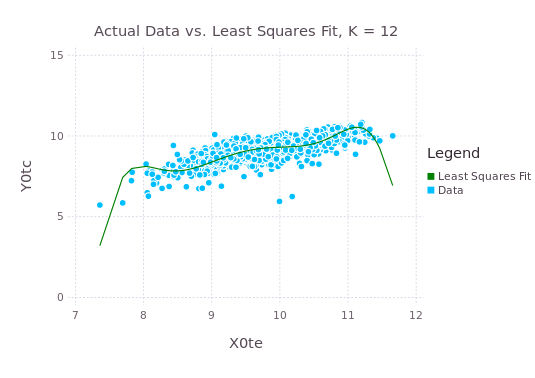

In [4]:
# MLE Estimate of basis function coefficients
W = GSO(X,K)
theta = inv(W'*W) * W' * Y
m = W * theta
plot(layer(x=X[:,2], y=m, Geom.line,Theme(default_color=colorant"green")),
        layer(x=X[:,2], y=Y, Geom.point),
        Guide.XLabel("X0te"),
        Guide.YLabel("Y0tc"),
        Guide.Title("Actual Data vs. Least Squares Fit, K = $K"),
Guide.manual_color_key("Legend",["Least Squares Fit","Data"],["green","deepskyblue"]))size()

### 3.

**Using the shrinkage estimator, estimate $m(X_i)$. Plot this on the unsmoothed data.**

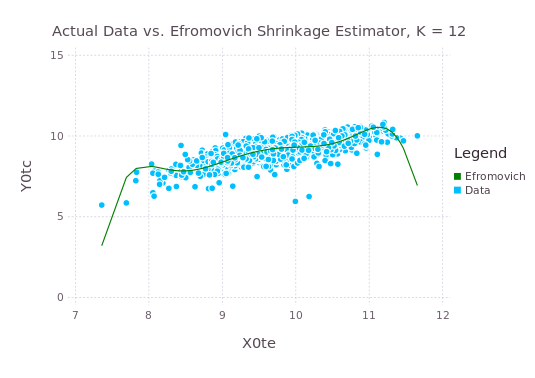

In [25]:
# MLE of Variance
# sigma2 = sum((Y - m).^2) / (length(Y)- K)
sigma2 = dot(Y-m, Y-m) / (length(Y)- K)

# Shrinkage Coefficients
function efromovich(Z::Array{Float64,1},var::Float64,N::Int64)
    shrinkage = similar(Z)
    for k = 1:length(shrinkage)
        shrinkage[k] = max(1 - (var/N)/Z[k]^2,0)
    end
    return shrinkage.*Z
end

# Plot the 
muse = W*efromovich(theta,sigma2,length(Y))
plot(layer(x=X[:,2], y=muse, Geom.line,Theme(default_color=colorant"green")),
    layer(x=X[:,2], y=Y, Geom.point),
    Guide.XLabel("X0te"),
    Guide.YLabel("Y0tc"),
    Guide.Title("Actual Data vs. Efromovich Shrinkage Estimator, K = $K"),
    Guide.manual_color_key("Legend",["Efromovich","Data"],["green","deepskyblue"]))

Comments: The Efromovich Shrinkage Estimator is very close to the Maximum Likelihood Estimator. The shrinkage coefficients are very close to 1.

### 4.

**Compute the Soft Threshold Estimate**

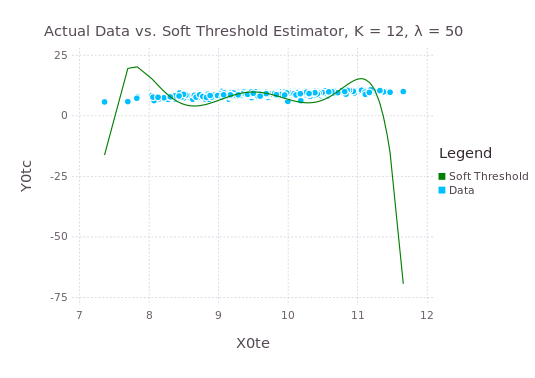

In [42]:
# Wasserman Soft Threshold Estimate
function wasserman(Z::Array{Float64,1}, lambda::Float64)
    theta = similar(Z)
    for k = 1:length(theta)
        theta[k] = sign(Z[k]) * (abs(Z[k]) - lambda) * (abs(Z[k]) > lambda)
    end
    return theta
end

# Plot the Soft Threshold Estimator on the Data
msoft = W*wasserman(theta,50.0)
plot(layer(x=X[:,2], y=msoft, Geom.line,Theme(default_color=colorant"green")),
    layer(x=X[:,2], y=Y, Geom.point),
    Guide.XLabel("X0te"),
    Guide.YLabel("Y0tc"),
    Guide.Title("Actual Data vs. Soft Threshold Estimator, K = $K, \u03BB = 50"),
    Guide.manual_color_key("Legend",["Soft Threshold","Data"],["green","deepskyblue"]))

## Income and Geography

In [10]:
# Code to read in the data
hjfile = open("HallJones400.asc")
hjdata = readlines(hjfile)

# Read in logYL and Latitude, skipping any observation that is
logYL = Array(Float64,1)
latitude = Array(Float64,0)
for line = 210:361
    if isnan(parse(Float64,hjdata[line][47:53]))
        continue
    end
    push!(logYL,parse(Float64,hjdata[line][47:53]))
    push!(latitude,parse(Float64,hjdata[line][196:202]))
end

### 2
**Using the power series basis, construct an Orthogonal Basis**